<div align="center">
  <a href="https://hopaas.cloud.infn.it">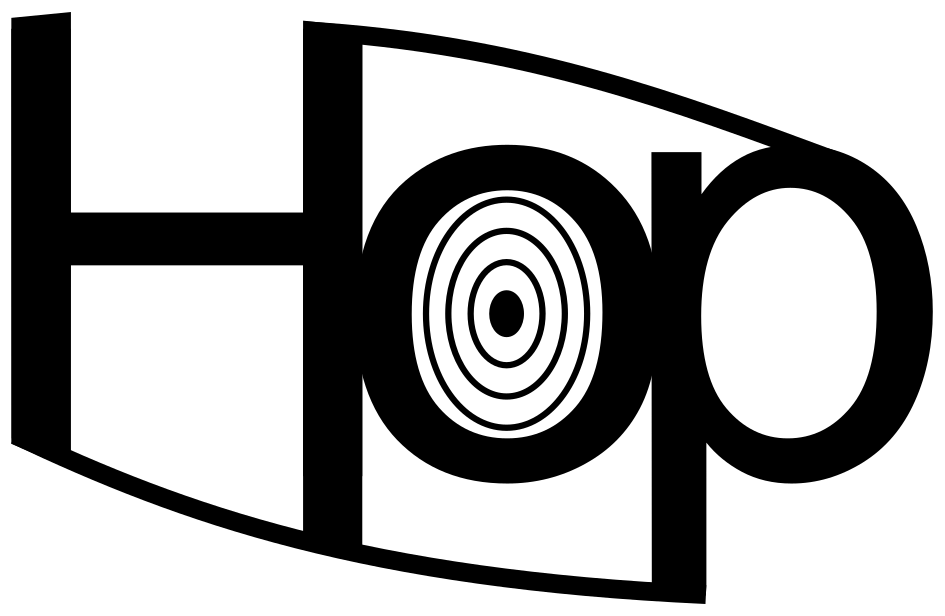</a>
</div>

<h3 align="center">
  <em>Hyperparameter optimization as a service</em>
</h3>

# Tutorial on Hopaas
In this notebook, similarly to what done in the [Tutorial on Optuna](https://colab.research.google.com/drive/1BMlyH2rtT0M20joS9-7Obise2U8Fmlr4?usp=sharing), we discuss a simple application of Hopaas to perform a $\chi^2$ fit. Let $X$ and $Y$ be the input and output datasets respectively, such that $y = \sin(\nu x + \varphi)$ where the parameters $\nu$ and $\varphi$ are to be determinated by the fit procedure.

Before starting, note that this is a particular challenging minimization process because it has many _local minima_ the optimizer will seek for. A common technique to address this problem is to initialize the minimization multiple times in a **random** way. Here, we will use **Bayesian search** instead of purely random initialization to speed-up _smartly_ the process.

## Let's code!

<table align="left">
  <td>
    <a href="https://github.com/landerlini/mlinfn-advanced-hackathon/blob/main/bayesian_optimization/hopaas_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/landerlini/mlinfn-advanced-hackathon/blob/main/bayesian_optimization/hopaas_tutorial.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>
  </td>
</table>

## Install and import `hopaas_client`
The GitHub repository for `hopaas_client`, a minimalisic front-end for the REST APIs of Hopaas, is https://github.com/landerli/hopaas_client.git.

We use `pip` to install it directly from the repository, while waiting for an official release in PyPI.

In [1]:
!pip install git+https://github.com/landerlini/hopaas_client.git > pip.log   # silent 'pip install' 

  Running command git clone -q https://github.com/landerlini/hopaas_client.git /tmp/pip-req-build-km7pvmyx


Then, we import several modules that we will use within this notebook (both for analysis and visualization).

In [2]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import hopaas_client as hpc
import matplotlib.pyplot as plt

## Data generation and visualization

In [3]:
v_true = 5
phi_true = 4

x_train = np.random.uniform(0, 5, 100)
y_train = np.sin(v_true * x_train + phi_true)

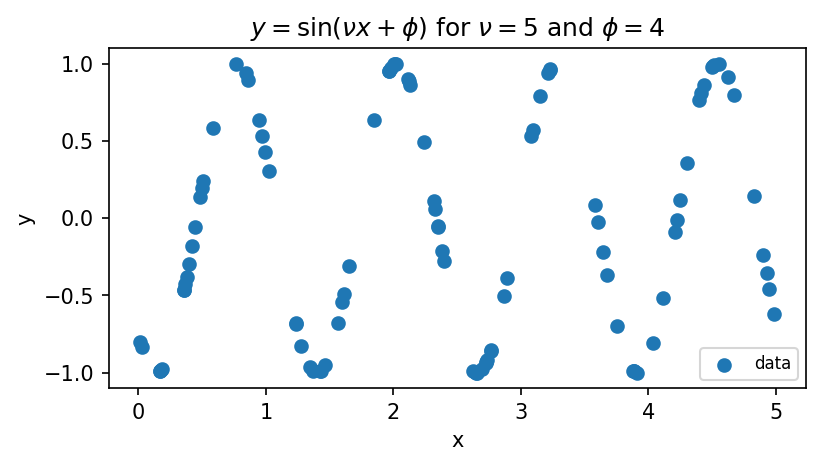

In [4]:
plt.figure(figsize=(6,3), dpi=150)
plt.title(rf"$y = \sin(\nu x + \phi)$ for $\nu={v_true}$ and $\phi={phi_true}$", fontsize=12)
plt.xlabel("x", fontsize=10)
plt.ylabel("y", fontsize=10)
plt.scatter(x_train, y_train, label="data")
plt.legend(loc="lower right", fontsize=8)
plt.show()

## Hopaas Client
Hopaas is a service hosted by [INFN Cloud](https://www.cloud.infn.it) that enables to build a **client-server system** for hyperparameter optimization. Thus, the first step to prepare an optimization study is to set up a `Client` instance passing the address of the Hopaas server and a valid authentication token.

In [5]:
client = hpc.Client(
    server="https://hopaas.cloud.infn.it",
    token="UjbXFqgA-X1JGjeTA-SLQGRq2x-Qj3QZNXq-QXnF7LCw-i95cygaC-tExiKIA3-RODg7KIs"   # it expires on 2022/11/30
)

## Hopaas Study
Instantiated the client, we can create a Hopaas `Study` that can be described as a **wrapper** to the Optuna `Study` class (see [Tutorial on Optuna](https://colab.research.google.com/drive/1BMlyH2rtT0M20joS9-7Obise2U8Fmlr4?usp=sharing) for more details). The main difference with the latter is the presence of the `properties` and `client` arguments:
* `properties` - dictionary containing the specifications for the set of hyperparameter to optimize;
* `client` - Hopaas `Client` instance needed to enable the remote connection with the optimization server.

Note that _all_ the information passed to `Study` is used to define a **unique identifier** (named `suid`) that allows to interact with the same study from different computing nodes as long as one sets the same settings for the optimization campaign (i.e. name, search space, sampler, ...).

In [6]:
study = hpc.Study(
    name = f"tutorial_hopaas_sin",
    properties = dict(v = hpc.suggestions.Float(0, 10), phi = hpc.suggestions.Float(-10, 10)),
    sampler = hpc.samplers.TPESampler(),
    pruner = hpc.pruners.MedianPruner(),
    client = client
  )

In [7]:
v_tf = tf.Variable(5.0)
phi_tf = tf.Variable(4.0)

vars = phi_tf, v_tf

def chi_square_fast():
  y = tf.sin(v_tf * x_train + phi_tf)
  return tf.reduce_mean(tf.square(y - y_train))

## Optimization loop
Hopaas needs that the optimization loop is written _explicitly_. This can be done relying on an **Ask-and-Tell interface** similar to the one provided by Optuna (see [Tutorial on Optuna](https://colab.research.google.com/drive/1BMlyH2rtT0M20joS9-7Obise2U8Fmlr4?usp=sharing) for more details). In particular, the ask step corresponds to a **HTTP request** from the computing node (like the machine where this notebook is running) to the optimization server asking for a set of hyperparameters to test. Retrieved the hyperparameter values (from the HTTP response), the client computes the objective function ($\chi^2$ in our case) and sends back to the server the result obtained through another HTTP request within the tell step.

In `hopaas_client`, the ask/tell steps are implemented through a `with` statement built upon the `Study` instance. In particular, when within this `with` statement we "call" the value of a hyperparameter (ex. `trial.v`), then we are implicitly running the ask step. On the other hand, when within the `with` statement we "set" the value of the loss (ex. `trial.loss = some_value`), then we are implicitly running the tell step.

In [8]:
local_trials = dict()

In [9]:
optimizer = tf.keras.optimizers.Adam(0.02)

for iTrial in range(15):
  with study.trial() as trial:
    pruned_trial = False
    
    v_tf.assign(trial.v)       # ASK the hyperparameter value from the Hopaas server
    phi_tf.assign(trial.phi)   # ASK the hyperparameter value from the Hopaas server

    print(f"Trial n.{trial.id:02} - v: {trial.v:.3f}, phi: {trial.phi:.3f}")

    for iStep in range(15):
      with tf.GradientTape() as tape:
        loss = chi_square_fast()
        grads = tape.gradient(loss, vars)
        optimizer.apply_gradients(zip(grads, vars))

        trial.loss = loss.numpy()   # TELL the loss value to the Hopaas server
        local_trials[trial.id] = dict(v=v_tf.numpy(), phi=phi_tf.numpy())

        if ((iStep+1) % 5) == 0:
          print(f".. Step n.{iStep:02} - loss: {loss:.3f} - v: {v_tf.numpy():.3f}, phi: {phi_tf.numpy():.3f}")

        if trial.should_prune:
          pruned_trial = True
          break

    if pruned_trial:
      print(".. TRIAL PRUNED")
    else:
      print(".. TRIAL COMPLETE")

Trial n.00 - v: 3.497, phi: -4.828
.. Step n.04 - loss: 1.116 - v: 3.597, phi: -4.727
.. Step n.09 - loss: 1.068 - v: 3.700, phi: -4.628
.. Step n.14 - loss: 1.033 - v: 3.800, phi: -4.565
.. TRIAL COMPLETE
Trial n.01 - v: 8.366, phi: 2.577
.. Step n.04 - loss: 0.845 - v: 8.355, phi: 2.513
.. Step n.09 - loss: 0.777 - v: 8.286, phi: 2.417
.. Step n.14 - loss: 0.753 - v: 8.217, phi: 2.335
.. TRIAL COMPLETE
Trial n.02 - v: 4.783, phi: 6.548
.. Step n.04 - loss: 1.241 - v: 4.685, phi: 6.445
.. Step n.09 - loss: 0.879 - v: 4.562, phi: 6.316
.. Step n.14 - loss: 0.616 - v: 4.441, phi: 6.184
.. TRIAL COMPLETE
Trial n.03 - v: 3.336, phi: 1.402
.. Step n.04 - loss: 1.095 - v: 3.240, phi: 1.300
.. Step n.09 - loss: 1.039 - v: 3.161, phi: 1.229
.. Step n.14 - loss: 0.996 - v: 3.091, phi: 1.177
.. TRIAL COMPLETE
Trial n.04 - v: 8.824, phi: 9.772
.. Step n.04 - loss: 1.145 - v: 8.800, phi: 9.756
.. Step n.09 - loss: 1.124 - v: 8.825, phi: 9.775
.. Step n.14 - loss: 1.065 - v: 8.878, phi: 9.815
.. T

## Results visualization

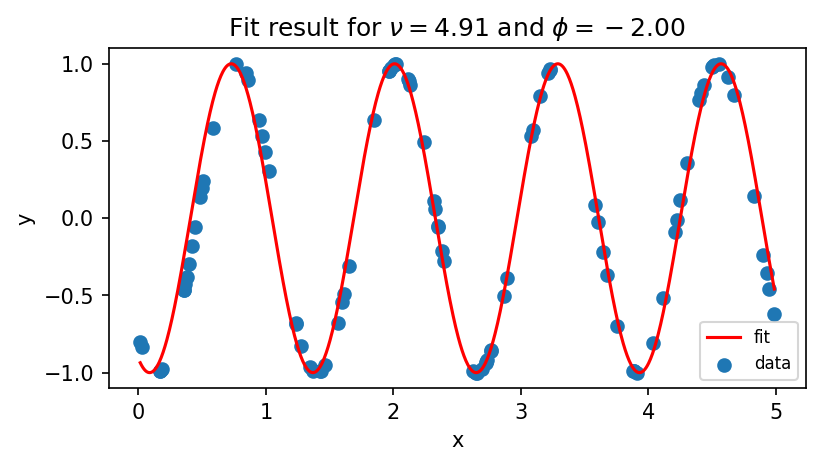

In [10]:
v_best = local_trials[study.best_trial_id]["v"]
phi_best = local_trials[study.best_trial_id]["phi"]

x_model = np.linspace(x_train.min(), x_train.max(), 1000)
y_model = np.sin(v_best * x_model + phi_best)

plt.figure(figsize=(6,3), dpi=150)
plt.title(rf"Fit result for $\nu = {v_best:.2f}$ and $\phi = {phi_best:.2f}$", fontsize=12)
plt.xlabel("x", fontsize=10)
plt.ylabel("y", fontsize=10)
plt.scatter(x_train, y_train, label="data")
plt.plot(x_model, y_model, color="r", label="fit")
plt.legend(loc="lower right", fontsize=8)
plt.show()